In [15]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

Per the course AI usage policy, I must say that I relied on chatgpt for help with processing the data from these unfamiliar files. However, I've taken lots of time to understand the process and adapt much of the code to my own needs. I've built my own logic, so the comments should reflect this and make it easy to read. 

I found the dataset takes ~5 minutes or less to read through and make into useable training and testing data

In [ ]:
# Only include chords that are major or minor (ignores maj7, dim, aug, sus, etc.)
VALID_QUALITIES = ['maj', 'min']

# Notes that have multiple names are mapped to only one name
ENHARMONIC_EQUIVS = {
    'B#': 'C', 
    'C#': 'Db',
    'D#': 'Eb',
    'Fb': 'E',
    'E#': 'F', 
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
    'Cb': 'B',
}

# Initialize lists to store mean chroma features over time (X) and chord labels (y)
X = []
y = []

# Define folder where the dataset is stored
data_path = "data/mcgill-billboard"

# Find paths to chord annotations and chroma metadata folders
annotation_dir = os.path.join(data_path, "annotations", "annotations")
metadata_dir = os.path.join(data_path, "metadata", "metadata")

# Make a list of every annotated track folder (one folder per track, e.g. 0003)
track_list = os.listdir(annotation_dir)

# Loop through every track folder in the annotation directory 
for track_id in tqdm(track_list):  # tqdm shows progress bar
    try:
        # Paths to the annotation and chroma data for this track
        lab_path = os.path.join(annotation_dir, track_id, "majmin.lab")
        chroma_path = os.path.join(metadata_dir, track_id, "bothchroma.csv")

        # If either file is missing, skip this track
        if not os.path.exists(lab_path) or not os.path.exists(chroma_path):
            continue

        # Read chroma CSV into a DataFrame
        df = pd.read_csv(chroma_path, header=None)

        # Drop any rows with NaN values
        df.dropna()

        # Name the columns: first 3 are metadata (audio path, time, duration)
        # The rest are assumed to be chroma values, named chroma_0 to chroma_11
        df.columns = ["audio_path", "time", "duration"] + [f"chroma_{i}" for i in range(df.shape[1] - 3)]

        # Open and read each line from the chord label file
        with open(lab_path, "r") as f:
            for line in f:
                # Split line into start time, end time, and label e.g., "0.000 1.500 C:maj"
                parts = line.strip().split()
                if len(parts) != 3:
                    continue  # skip malformed lines, should only have 3 parts

                start, end, label = parts

                # Skip labels that don’t include “:” (like "N" or malformed entries)
                if ':' not in label:
                    continue

                # Split chord quality from root (e.g., "C:maj" → "C", "maj"), then check if valid
                root, quality = label.split(':', 1)
                
                if quality not in VALID_QUALITIES:
                    continue

                #If root is an enharmonically equivalent note, convert it
                if root in ENHARMONIC_EQUIVS:
                    root = ENHARMONIC_EQUIVS[root]

                # Convert start and end times to float from strings
                start = float(start)
                end = float(end)

                # Select only chroma rows whose timestamps fall within the current chord segment
                segment = df[(df["time"] >= start) & (df["time"] < end)]

                # If no chroma rows are found for this time range, skip it
                if len(segment) == 0:
                    continue

                # Define the 12 chroma pitch class columns (C, C#, ..., B as chroma_0 to chroma_11)
                chroma_cols = [f"chroma_{i}" for i in range(12)]

                # Compute the mean chroma across the selected time range
                chroma_mean = segment[chroma_cols].mean().values

                X.append(chroma_mean)
                y.append(root + quality)  # full label, e.g. "Cmaj"

    except Exception as e:
        # Print the error if something goes wrong with this track
        print(f"Error with track {track_id}: {e}")

100%|██████████| 890/890 [03:04<00:00,  4.82it/s]


### Split Data

In [17]:
X = np.array(X)
y = np.array(y)

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model - Decision Tree

In [18]:
# Create and train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test set
dt_y_pred = dt_model.predict(X_test)
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, dt_y_pred))

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

       Abmaj       0.72      0.73      0.72       932
       Abmin       0.40      0.43      0.42       141
        Amaj       0.67      0.66      0.67      1985
        Amin       0.48      0.49      0.48       764
       Bbmaj       0.73      0.70      0.71      1186
       Bbmin       0.60      0.60      0.60       189
        Bmaj       0.67      0.65      0.66       901
        Bmin       0.60      0.61      0.61       618
        Cmaj       0.74      0.74      0.74      2186
        Cmin       0.54      0.50      0.52       358
       Dbmaj       0.65      0.66      0.66       647
       Dbmin       0.65      0.70      0.67       315
        Dmaj       0.70      0.69      0.70      2162
        Dmin       0.50      0.51      0.51       722
       Ebmaj       0.72      0.73      0.72       793
       Ebmin       0.57      0.57      0.57       306
        Emaj       0.71      0.71

### Confusion Matrix - Decision Tree

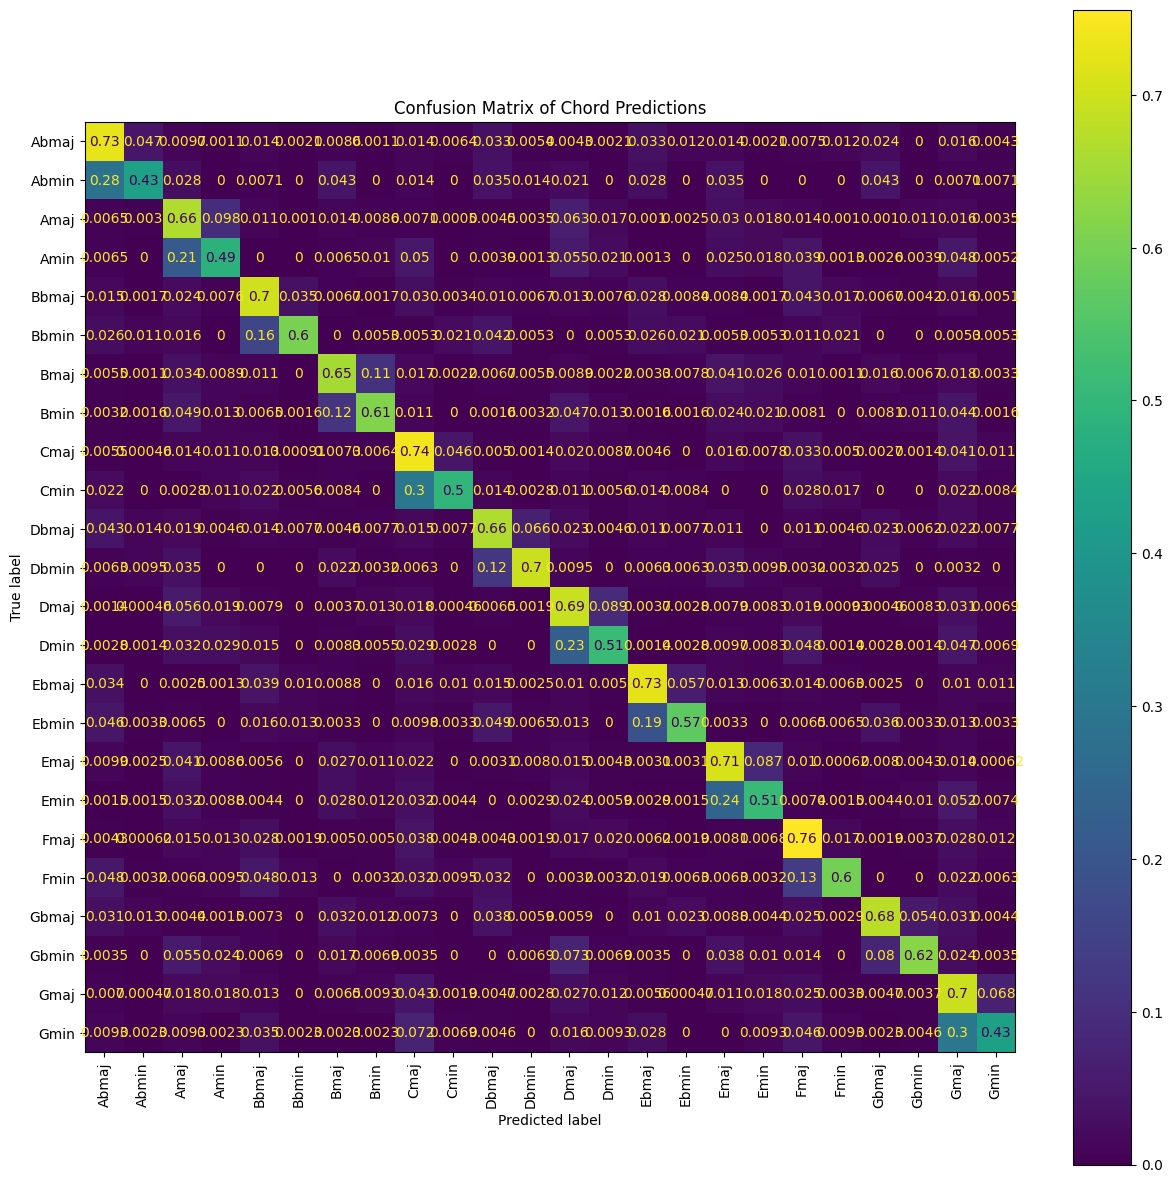

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CHORD_LABELS = ['Abmaj', 'Abmin', 'Amaj', 'Amin', 'Bbmaj', 'Bbmin', 'Bmaj', 'Bmin', 
        'Cmaj', 'Cmin', 'Dbmaj', 'Dbmin', 'Dmaj', 'Dmin', 'Ebmaj', 'Ebmin', 'Emaj', 'Emin', 
        'Fmaj', 'Fmin', 'Gbmaj', 'Gbmin', 'Gmaj', 'Gmin']

cm = confusion_matrix(y_test, dt_y_pred, labels=CHORD_LABELS, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CHORD_LABELS)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix of Chord Predictions")
plt.show()

### Train Model - Random Forest

In [20]:
# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
rf_y_pred = rf_model.predict(X_test)
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

       Abmaj       0.77      0.86      0.81       932
       Abmin       0.84      0.41      0.55       141
        Amaj       0.72      0.85      0.78      1985
        Amin       0.77      0.52      0.62       764
       Bbmaj       0.81      0.84      0.83      1186
       Bbmin       0.94      0.65      0.76       189
        Bmaj       0.79      0.79      0.79       901
        Bmin       0.77      0.72      0.74       618
        Cmaj       0.79      0.86      0.82      2186
        Cmin       0.82      0.44      0.58       358
       Dbmaj       0.78      0.78      0.78       647
       Dbmin       0.84      0.76      0.80       315
        Dmaj       0.78      0.84      0.81      2162
        Dmin       0.79      0.55      0.65       722
       Ebmaj       0.79      0.84      0.81       793
       Ebmin       0.83      0.64      0.72       306
        Emaj       0.78      0.86

### Confusion Matrix - Random Forest

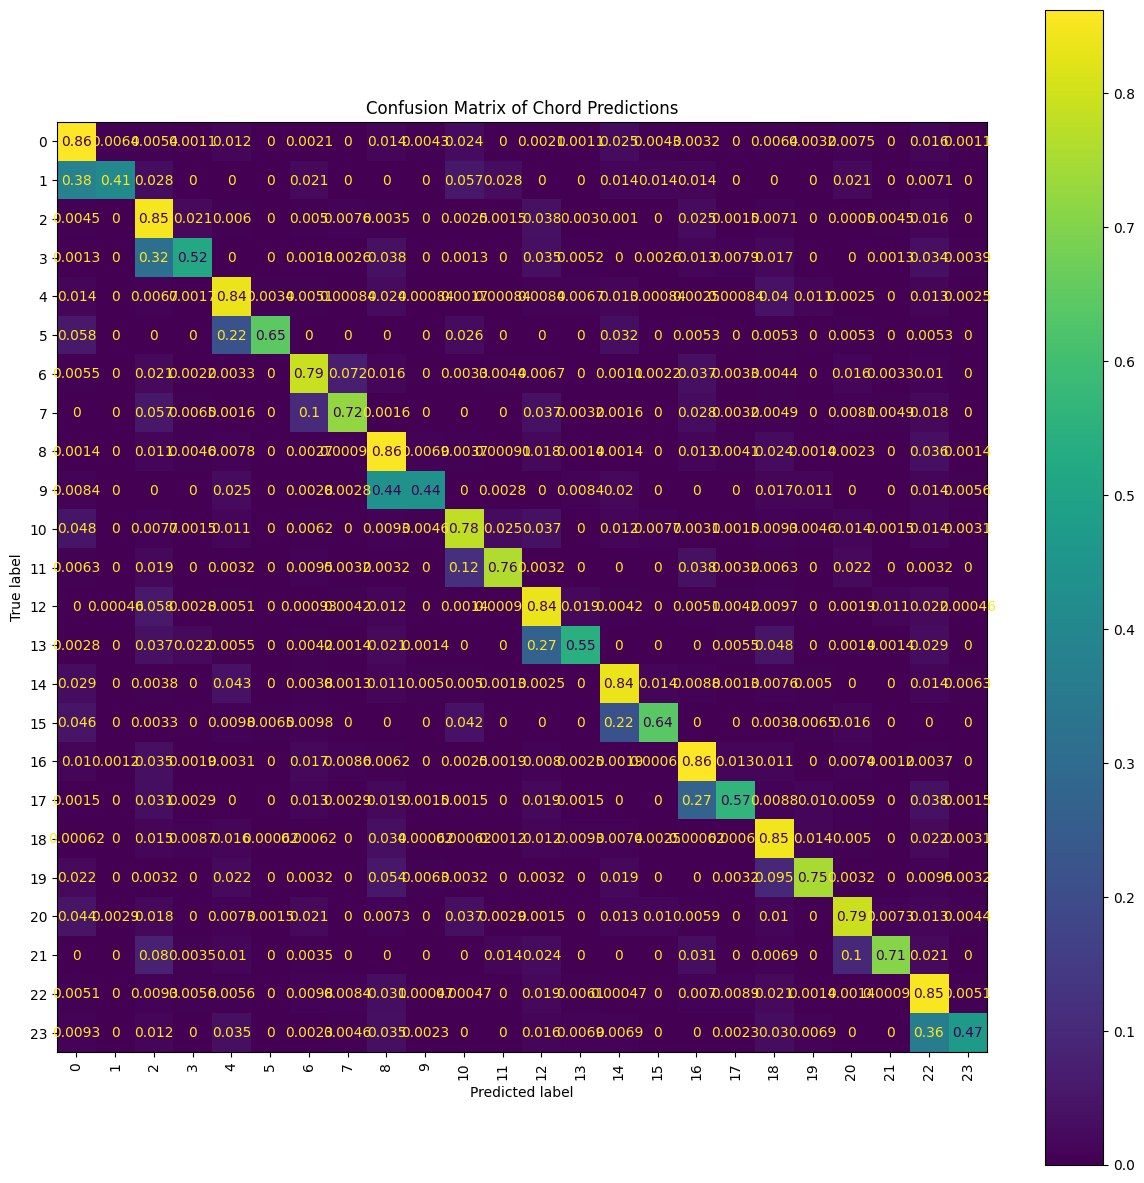

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CHORD_LABELS = ['Abmaj', 'Abmin', 'Amaj', 'Amin', 'Bbmaj', 'Bbmin', 'Bmaj', 'Bmin', 
        'Cmaj', 'Cmin', 'Dbmaj', 'Dbmin', 'Dmaj', 'Dmin', 'Ebmaj', 'Ebmin', 'Emaj', 'Emin', 
        'Fmaj', 'Fmin', 'Gbmaj', 'Gbmin', 'Gmaj', 'Gmin']

cm = confusion_matrix(y_test, rf_y_pred, labels=CHORD_LABELS, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CHORD_LABELS)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix of Chord Predictions")
plt.show()

## Analysis

### Results
Originally, I was getting precision values varying in the range from 0.50 to 0.90 (on random forest).

Then, I realized that enharmonic notes were messing up the data. Harmonically, C#maj is the same as Dbmaj, and had to be treated as such when training. This also gave more data on each category, giving chords without many examples like D#min twice as many examples after being combined with Ebmin.

After that, precision rose for all categories to a range of 0.75 to 0.95.

It seems that on both models, minor chords were most commonly confused for their major counterpart. This makes sense, as they only differ by one note. However, as for why it wasn’t confused as much the other way around, if I had to guess, power chords threw it off. Power chords lack the middle note that would identify it as minor (C, Eb, G) -> (C, G). These are especially common in rock songs, which also happen to use a lot of minor chords. If the data is mostly comprised of top songs from the '50s to '90s, there's bound to be some power chords mixed in.

### Use Case + Future Plans
This will be most useful in times where you know a chord change happens, but can't identify it.

With a model trained on more examples of different types of chords and extensions (7, 9, 11..), it would be nice to also know the runners-up, since the same chroma data could be classified in multiple ways (Amin7 could be written as Cmaj6, depends on context).

If this project was to be an application and not a notebook, the next step could be to have live audio input for real-time feedback.